# Model 1: no cell movement

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import math


def neighbors(field,radius: int,cell_type: int,x,y):
    # Slicing the neighborhood around the cell
    neighborhood = field[max(0, x-radius):min(field.shape[0], x+radius+1),
                        max(0, y-radius):min(field.shape[1], y+radius+1)]
                    
    # Count occurrences of each species in the neighborhood
    return(np.count_nonzero(neighborhood == cell_type))

'''
def neighbors(field, radius: int, cell_type: int, x, y):
    max_x, max_y = field.shape
    
    # Create an empty mask with the same shape as the neighborhood
    mask = np.zeros((2 * radius + 1, 2 * radius + 1), dtype=bool)
    
    # Fill the mask with True values within the circular boundary
    for i in range(2 * radius + 1):
        for j in range(2 * radius + 1):
            if (i - radius) ** 2 + (j - radius) ** 2 <= radius ** 2:
                mask[i, j] = True
    
    # Calculate the bounds for the neighborhood indices
    min_x = max(0, x - radius)
    max_x = min(max_x, x + radius + 1)
    min_y = max(0, y - radius)
    max_y = min(max_y, y + radius + 1)
    
    # Slice the neighborhood around the cell and apply the mask
    neighborhood = field[min_x:max_x, min_y:max_y]
    neighborhood[~mask[:max_x - min_x, :max_y - min_y]] = 0
    #plt.imshow(neighborhood, cmap=ListedColormap(['white', 'black', 'yellow']), interpolation='nearest')
    #plt.show()
    # Count occurrences of the cell type in the neighborhood
    return np.count_nonzero(neighborhood == cell_type)

'''


def update(field):
    # parameters:
    prod_rate_1=0.01
    prod_rate_2=0.01
    death_rate_1=0.01
    death_rate_2=0.001
    short_range=2
    long_range=10
    
    new_field = np.copy(field)  # Make a copy to avoid modifying the original array directly
    for x in range(field.shape[0]):
        for y in range(field.shape[1]):
             
            # Count occurrences of each species in the neighborhood
            neighbours_1 = neighbors(field,short_range,1,x,y)
            neighbours_2 = neighbors(field,short_range,2,x,y)
            
            
            rand=random.random()       
            
            # base production of cells:
            if field[x,y]==0:
                if rand<prod_rate_1: new_field[x,y]=1
                if rand>1-prod_rate_2: new_field[x,y]=2
                        
            # death of cells: 
            if field[x,y]==1 and rand<death_rate_1: new_field[x,y]=0
            if field[x,y]==2 and rand<death_rate_2: new_field[x,y]=0
                        
            # induced cell death:        
            if field[x,y]==1 and neighbours_2>2*short_range**2: new_field[x,y]=0
            if field[x,y]==2 and neighbours_1>4*short_range**2: new_field[x,y]=0
                
            # positive feedback loop:
            if field[x,y]==0 and neighbors(field,long_range,2,x,y)>0.7*long_range**2: 
                new_field[x,y]=1         
                    
    return new_field




def run(field,n):
    print(f"Iteration {0}:")
    plt.imshow(field, cmap=ListedColormap(['white', 'black', 'yellow']), interpolation='nearest')
    plt.show()

    # Update the field in a loop and visualize the changes
    for i in range(n):
        field = update(field)
        if (i+1)%5==0:
            print(f"Iteration {i + 1}:")
            plt.imshow(field, cmap=ListedColormap(['white', 'black', 'yellow']), interpolation='nearest')
            plt.show()


Iteration 0:


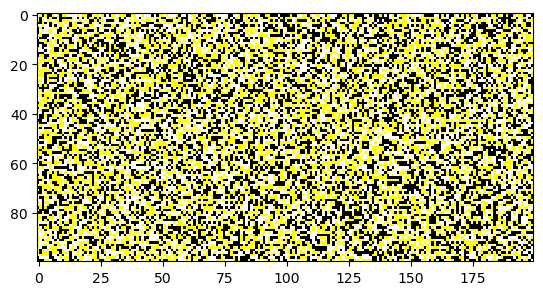

Iteration 5:


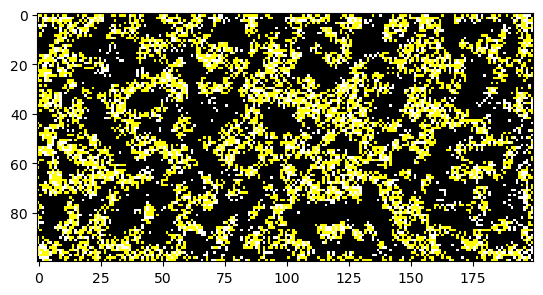

Iteration 10:


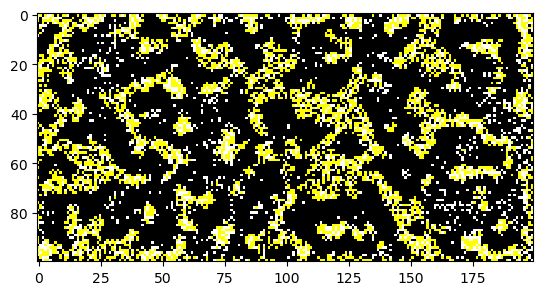

Iteration 15:


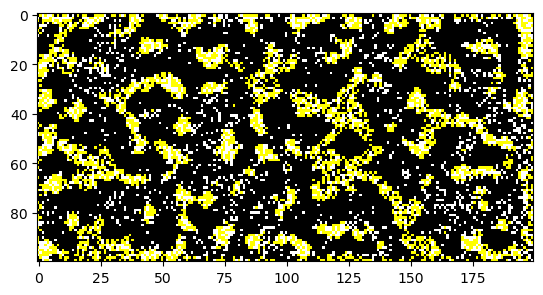

Iteration 20:


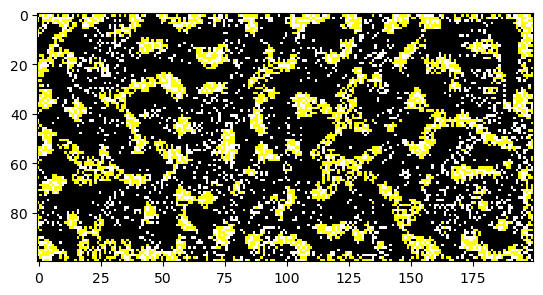

Iteration 25:


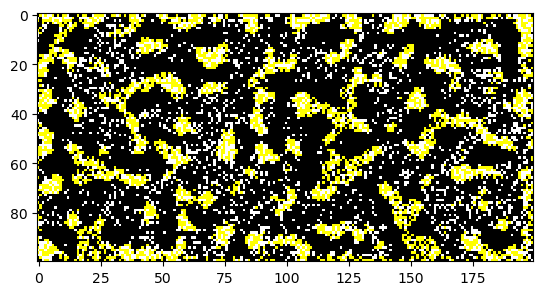

Iteration 30:


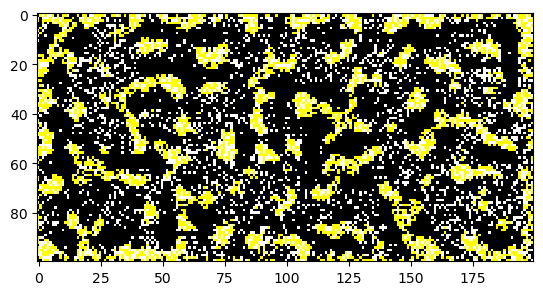

Iteration 35:


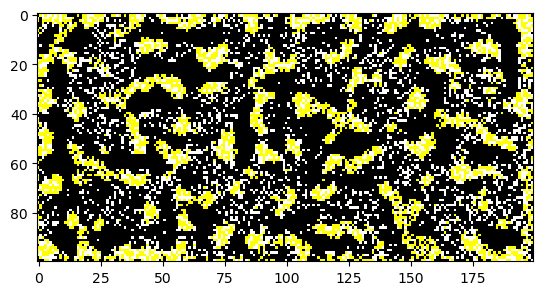

Iteration 40:


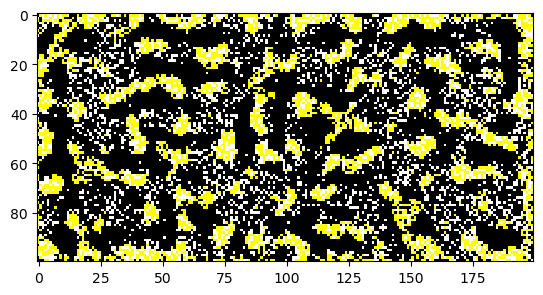

Iteration 45:


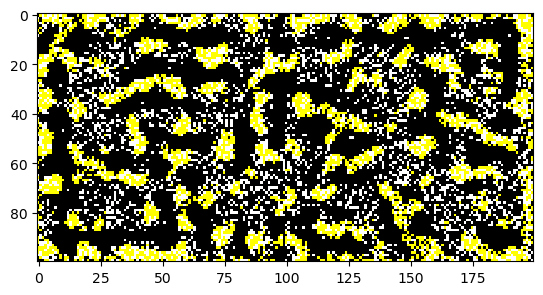

Iteration 50:


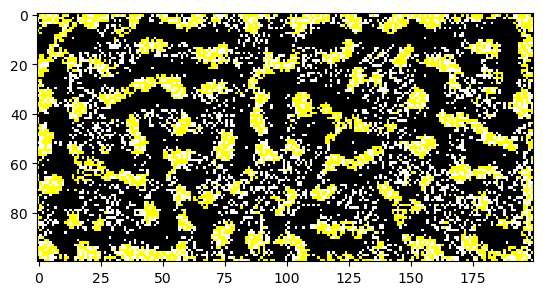

In [67]:
size_x = 100
size_y = 200
values = [0, 1, 2]  # Values to choose from


# Generate a random array of size x size with values 0, 1, or 2 based on probabilities
field = np.random.choice(values, size=(size_x, size_y))
#field=np.zeros((size_x,size_y))


run(field,50)

# Model 2: cell movement

In [4]:
from itertools import product

def find_spot(array, cell_type, target_x, target_y):
    window_size=4
    # Extract the window around the target position
    min_row = max(0, target_x - window_size)
    max_row = min(array.shape[0], target_x + window_size + 1)
    min_col = max(0, target_y - window_size)
    max_col = min(array.shape[1], target_y + window_size + 1)

    window = array[min_row:max_row, min_col:max_col]

    # Find indices of zeros within the window
    zero_indices = np.argwhere(window == 0)

    if len(zero_indices) == 0:
        return True  # No zeros found within the window

    # Calculate distances from each zero position to the target
    zero_positions = zero_indices + np.array([min_row, min_col])
    target_position = (target_x, target_y)
    distances = [np.linalg.norm(np.array(target_position) - zero_pos) for zero_pos in zero_positions]

    # Find the index of the minimum distance
    min_distance_index = np.argmin(distances)

    # Get the position of the closest zero entry to the target
    closest_zero_position = zero_positions[min_distance_index]

    array[closest_zero_position[0],closest_zero_position[1]]=cell_type
    return False

def get_vector(field,radius,cell_type,x,y):
    vector=np.zeros(2)
    d=2*radius+1
    directions=np.array(list(product([-d,0,d],[-d,0,d])))
    for a in directions:
        i=a[0]
        j=a[1]
        number=neighbors(field,radius,cell_type,x+i,y+j)
        vector+=number*a*(radius+1)**(-1)
    return vector



def update_2(field):
    # parameters:
    prod_rate_1=0.01
    prod_rate_2=0.01
    death_rate_1=0
    death_rate_2=0
    contact_range=0
    short_range=2
    long_range=15
    
    new_field = np.zeros((field.shape[0],field.shape[1]))  # Make a copy to avoid modifying the original array directly
    
    
    # Shuffle the indices
    indices = [(x, y) for x in range(field.shape[0]) for y in range(field.shape[1])]
    random.shuffle(indices)
    
    # Iterate through the grid using shuffled indices
    for (x,y) in indices:
            vector=np.zeros(2)
            if field[x,y]==1:
                vector=-get_vector(field,short_range,1,x,y)*0.1
                vector+=-get_vector(field,short_range,2,x,y)*0.2         
                #vector+=get_vector(field,long_range,2,x,y)*0.2                             
                
                vector=vector.astype(int)
                
                #find new spot to move cell to
                if 0<=x+vector[0]<field.shape[0] and 0<=y+vector[1]<field.shape[1]:
                    find_spot(new_field,1,x+vector[0],y+vector[1])
                else: find_spot(new_field,1,x,y)
                    
                    
            elif field[x,y]==2:     
                vector=-get_vector(field,short_range,2,x,y)*0.1
                vector+=-get_vector(field,short_range,1,x,y)*0.2
                vector+=get_vector(field,contact_range,1,x,y)*0.1
                vector=vector.astype(int)
                
                #find new spot to move cell to
                if 0<=x+vector[0]<field.shape[0] and 0<=y+vector[1]<field.shape[1]:
                    find_spot(new_field,2,x+vector[0],y+vector[1])
                else: find_spot(new_field,2,x,y)
                
            # Count occurrences of each species in the 1 neighborhood
            neighbours_1 = neighbors(field,short_range,1,x,y)
            neighbours_2 = neighbors(field,short_range,2,x,y)
            
            
            rand=random.random()      
            
            # base production of cells:
            if new_field[x,y]==0:
                if rand<prod_rate_1: new_field[x,y]=1
                if rand>1-prod_rate_2: new_field[x,y]=2
                    
            # death of cells:
            if new_field[x,y]==1 and rand<death_rate_1: new_field[x,y]=0
            if new_field[x,y]==2 and rand<death_rate_2: new_field[x,y]=0
                        
            # induced cell death:        
            if field[x,y]==1 and neighbours_2>2*short_range**2: new_field[x,y]=0
            if field[x,y]==2 and neighbours_1>4*short_range**2: new_field[x,y]=0        
    return new_field




def run_2(field,n):
    print(f"Iteration {0}:")
    plt.imshow(field, cmap=ListedColormap(['white', 'black', 'yellow']), interpolation='nearest')
    plt.show()

    # Update the field in a loop and visualize the changes
    for i in range(n):
        field = update_2(field)
        if (i+1)%5==0:
            print(f"Iteration {i + 1}:")
            plt.imshow(field, cmap=ListedColormap(['white', 'black', 'yellow']), interpolation='nearest')
            plt.show()

Iteration 0:


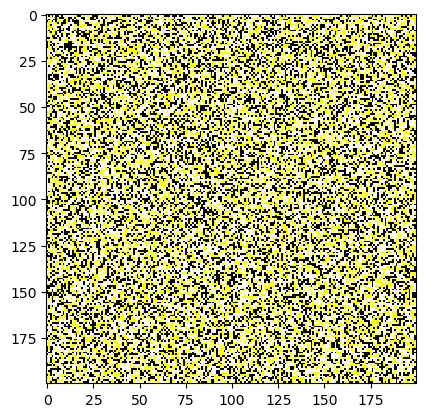

Iteration 5:


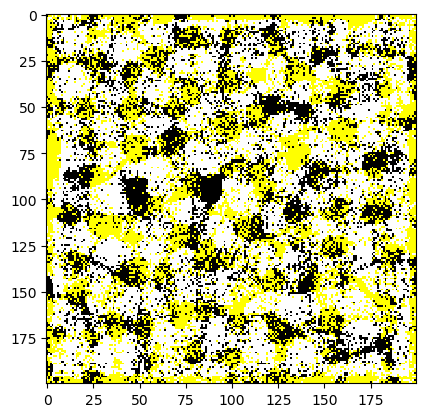

Iteration 10:


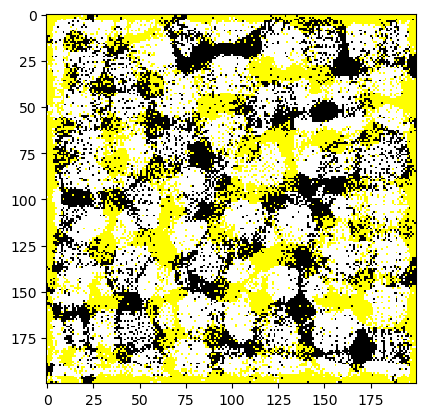

Iteration 15:


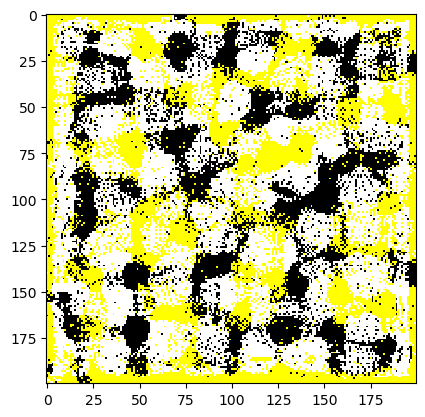

Iteration 20:


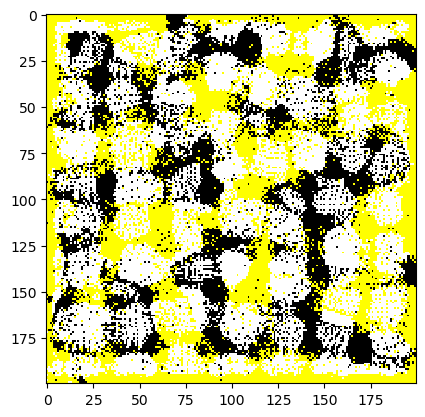

Iteration 25:


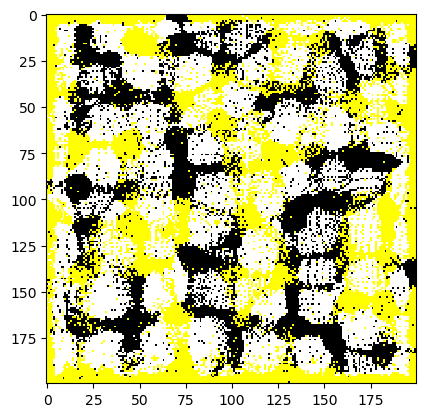

Iteration 30:


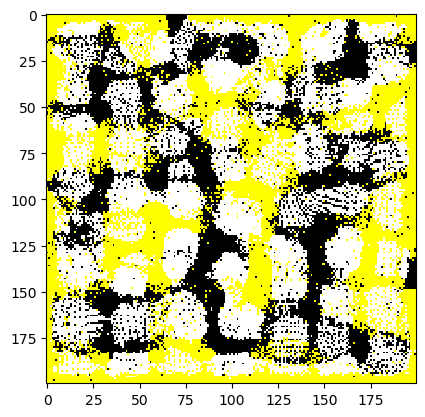

Iteration 35:


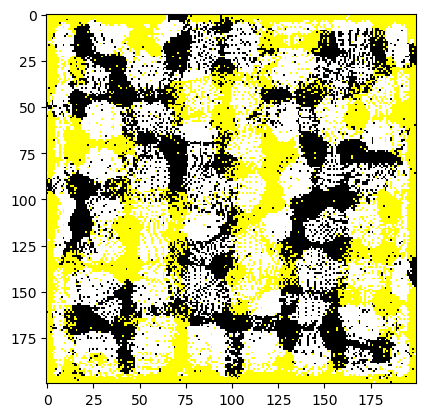

Iteration 40:


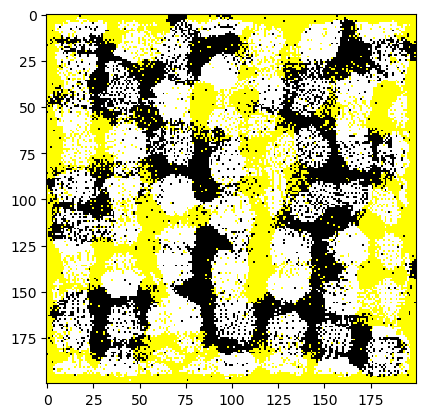

Iteration 45:


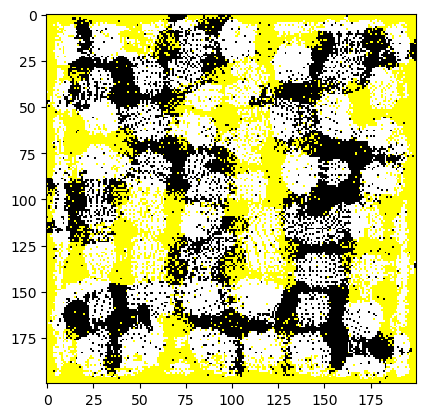

Iteration 50:


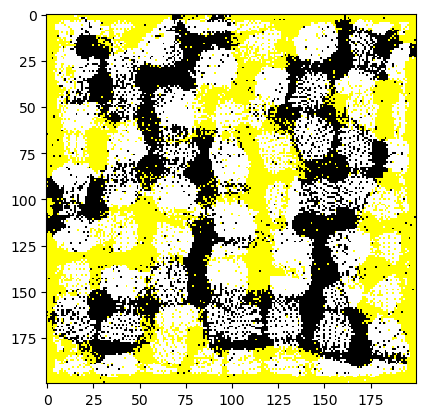

In [6]:
size_x = 200
size_y = 200
values = [0, 1, 2]  # Values to choose from

probabilities = [0.4, .3, .3]  # Probabilities for 0, 1, 2 respectively

# Generate a random array of size x size with values 0, 1, or 2 based on probabilities
field = np.random.choice(values, size=(size_x, size_y),p=probabilities)
#field=np.zeros((size_x,size_y))


run_2(field,50)

# Regeneration experiment

Iteration 0:


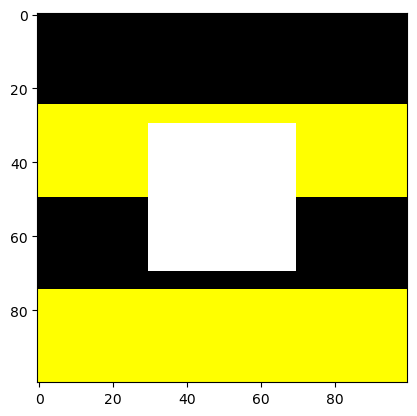

Iteration 5:


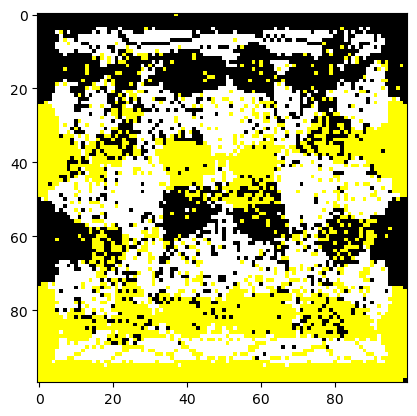

Iteration 10:


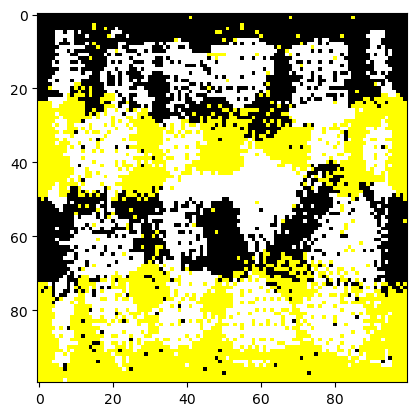

Iteration 15:


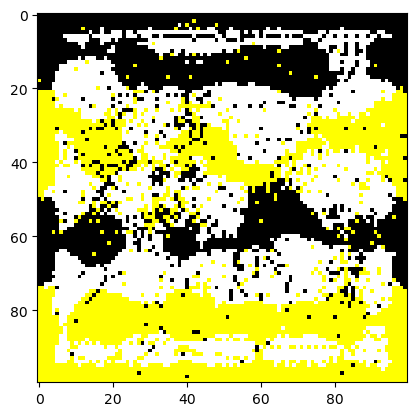

Iteration 20:


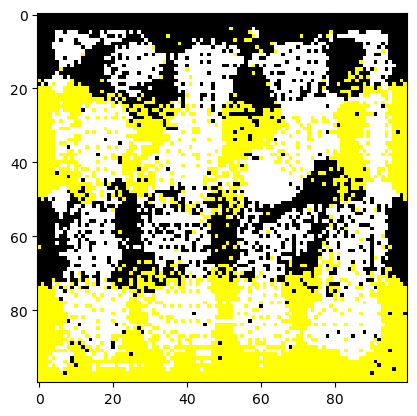

In [71]:
def create_striped_array(size, stripe_width):
    array = np.zeros((size, size), dtype=int)
    for i in range(size):
        # Calculate the start and end indices for each stripe
        start = (i // stripe_width) * stripe_width
        end = start + stripe_width
        
        # Assign values based on the stripe pattern
        array[i,:] = (i // stripe_width) % 2 + 1
    
    return array




size = 100
stripe_width = 25
result_array = create_striped_array(size, stripe_width)
field = np.random.choice(values, size=(40, 40))
field = np.zeros((40,40))
result_array[30:70,30:70]=field
run_2(result_array,20)
